<a href="https://colab.research.google.com/github/PawelJakubczyk/mln_ham_or_spam_classifier/blob/main/spam_or_ham.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup: Install Required Libraries

In [1]:
%pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 24.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!python -m spacy download en_core_web_sm

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.1/12.8 MB 1.5 MB/s eta 0:00:09
      --------------------------------------- 0.2/12.8 MB 2.1 MB/s eta 0:00:07
     - -------------------------------------- 0.4/12.8 MB 2.8 MB/s eta 0:00:05
     -- ------------------------------------- 0.7/12.8 MB 3.5 MB/s eta 0:00:04
     -- ------------------------------------- 0.9/12.8 MB 4.2 MB/s eta 0:00:03
     --- ------------------------------------ 1.2/12.8 MB 4.6 MB/s eta 0:00:03
     ---- ----------------------------------- 1.5/12.8 MB 4.9 MB/s eta 0:00:03
     ----- ---------------------------------- 1.7/12.8 MB 4.8 MB/s eta 0:00:03
     ------ --------------------------------- 2.0/12.8 MB 5.0 MB/s eta 0:00:03
     ------- -------------------------------- 2.3/12.8 MB 5.1 MB/s eta 0:00:03
     -------- ------------------------------- 2.6/12.8 MB 5.


[notice] A new release of pip is available: 23.0.1 -> 24.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Data Sorce

## https://www.kaggle.com/datasets/mfaisalqureshi/spam-email

# Import Libraries

In [3]:
# Read manage data
import pandas as pd
import numpy as np

# Data Preprocesing
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from re import sub, findall
import string
import nltk
import spacy
from language_tool_python import LanguageTool
from collections import Counter
import logging

# data augmentation
from textaugment import Wordnet

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Data Analiss
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

# Model Training
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

# Define Functions

### Data cleaning

1. **normalize_text(input_text: str) -> str**:
   This function normalizes the input text by converting it to lowercase and removing leading/trailing whitespaces.

2. **remove_punctuation(input_string: str) -> str**:
   This function removes punctuation marks from the input string.

3. **replace_tabs_enters_and_spaces(input_string:str) -> str**:
   This function takes an input string and replaces tabs with a single space and multiple consecutive spaces with a single space.

4. **remove_stopwords(input_string: str) -> str**:
   This function removes stopwords from the input string. Stopwords are commonly used words (e.g., "the", "is", "in") that do not carry significant meaning.

5. **remove_html_tags(input_text: str) -> str**:
   This function removes HTML tags from the input text.

6. **remove_stopwords(input_string: str, stop_words: Set[str]) -> str**:
   This function removes stopwords from the input string. Stopwords are commonly used words (e.g., "the", "is", "in") that do not carry significant meaning.

7. **lemmatize(text: str) -> str**:
   This function lemmatizes the input text. Lemmatization is similar to stemming but considers the context of the word to determine its base or dictionary form.

8. **stemming(text: str) -> str**:
   This function performs stemming on the input text. Stemming reduces words to their root or base form, often by removing suffixes.

    **Note:** It is recommended to avoid using lemmatization (`lemmatize`) and stemming (`stemming`) simultaneously, as both methods serve to normalize words but in different ways. Using them together may lead to excessive text processing and loss of semantic information.

9. **remove_pos_tags(text: str) -> str**:
   This function removes all words from the input text except for nouns (NN). It relies on part-of-speech tagging to identify and retain only nouns in the text.

10. **correct_grammar(text: str) -> str**:
    This function corrects grammar mistakes in the input text.

11. **remove_common_words(text: str, common_threshold: int) -> str**:
    This function removes words from the text that occur too frequently.

12. **remove_rare_words(text: str, rare_threshold: int) -> str**:
    This function removes words from the text that occur too rarely.

13. **clean_empty_data(df: pd.DataFrame, columns_to_check: list) -> pd.DataFrame**:
    Cleans the input DataFrame by removing rows with missing value or empty strings.



In [4]:
# Prior to running the functions, required resources need to be downloaded
nltk.download('punkt')
nltk.download('stopwords')
nlp = spacy.load('en_core_web_sm')
stop_words = nlp.Defaults.stop_words
stemmer = PorterStemmer()
language_tool = LanguageTool('en-US')

def normalize_text(input_string: str) -> str:
    """Normalizes the input text by converting it to lowercase and removing leading/trailing whitespaces."""
    # Convert to lowercase
    normalized_text = input_string.lower()

    # Remove leading and trailing whitespaces
    normalized_text = normalized_text.strip()

    return normalized_text

def remove_punctuation(input_string: str) -> str:
    """Removes punctuation from the input string"""
    return input_string.translate(str.maketrans('', '', string.punctuation))

def replace_tabs_enters_and_spaces(input_string:str) -> str:
    """Replaces tabs with a single space and multiple spaces with a single space in the input string"""
    replaced_tabs = sub(r'\t', ' ', input_string)
    replace_enters = sub(r'\n', ' ', replaced_tabs)
    replaced_spaces = sub(r'\s+', ' ', replace_enters)
    return replaced_spaces

def remove_html_tags(input_string: str) -> str:
    """Removes HTML tags from the input text."""
    clean_text = sub(r'<.*?>', '', input_string)
    return clean_text

def remove_stopwords(input_string: str) -> str:
    """Removes stopwords from the input string"""
    words = input_string.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

def lemmatize(input_string: str)-> str:
    """Lemmatizes the input text"""
    doc = nlp(input_string)
    sent = [token.lemma_ for token in doc if token.text not in stop_words]
    return ' '.join(sent)

def stemming(input_string: str)-> str:
    """Performs stemming on the input text"""
    tokens = word_tokenize(input_string)
    stem_words = [stemmer.stem(word) for word in tokens]
    return ' '.join(stem_words)

def remove_pos_tags(input_string: str)-> str:
    """Removes all words except nouns (NN) from the input text"""
    doc = nlp(input_string)
    sent = [token.text for token in doc if token.tag_ == 'NN']
    return ' '.join(sent)

def correct_grammar(input_string: str) -> str:
    """Corrects grammar mistakes in the input text."""
    corrected_text = language_tool.correct(input_string)
    return corrected_text

def remove_common_words(df: pd.DataFrame, column_name: str, common_threshold: int) -> pd.DataFrame:
    """Removes common words from the text in the specified DataFrame column."""
    words = df[column_name].str.lower().str.findall(r'\b\w+\b').sum()
    word_counts = Counter(words)
    common_words = {word for word, count in word_counts.items() if count > common_threshold}
    df[column_name] = df[column_name].apply(lambda text: ' '.join(word for word in text.lower().split() if word not in common_words))
    return df

def remove_rare_words(df: pd.DataFrame, column_name: str, rare_threshold: int) -> pd.DataFrame:
    """Removes rare words from the text in the specified DataFrame column."""
    words = df[column_name].str.lower().str.findall(r'\b\w+\b').sum()
    word_counts = Counter(words)
    rare_words = {word for word, count in word_counts.items() if count <= rare_threshold}
    df[column_name] = df[column_name].apply(lambda text: ' '.join(word for word in text.lower().split() if word not in rare_words))
    return df

def clean_empty_data(df: pd.DataFrame, columns_to_check: list) -> pd.DataFrame:
    """Cleans the input DataFrame by removing rows with incorrect or invalid values."""
    # Make a copy to avoid modifying the original DataFrame
    cleaned_df = df.copy()

    for column in columns_to_check:
        cleaned_df = cleaned_df[cleaned_df[column].notna()]
        cleaned_df = cleaned_df[cleaned_df[column] != ""]

    return cleaned_df

# Only the first thre preprocessing functions are used because they have the highest percentage of coverage in the model.
# The remaining functions are left in the notebook to demonstrate various preprocessing options.

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pawel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pawel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Merge functions for preprocesing

In [5]:
def preprocess_text(input_string: str) -> str:
    """Preprocesses the input text by applying a series of text processing steps."""
    # Step 1: normalize_text
    processed_text = normalize_text(input_string)
    # Step 2: Remove punctuation
    processed_text = remove_punctuation(processed_text)
    # Step 3: Replace tabs, enters, and multiple spaces with single spaces
    processed_text = replace_tabs_enters_and_spaces(processed_text)

    return processed_text

### Data augmentation

1. **augment_data(data, topic_col, text_col) -> DataFrame**: Data augmentation is a technique used to artificially increase the size of a dataset by creating modified versions of existing data samples. The `augment_data` function implements this technique by generating additional samples for underrepresented topics in the input data.

In [6]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

def augment_data(data: pd.DataFrame, topic_col: str, text_col: str) -> pd.DataFrame:
    """Augments the input data by generating additional samples for underrepresented topics."""

    topic_counts = data[topic_col].value_counts()  # get the topic counts
    max_count = topic_counts.max()  # max items for main topic

    augmented_data = []
    wordnet_aug = Wordnet(v=True)  # use Wordnet for synonyms

    # Loop through each topic to create additional data
    for topic, count in topic_counts.items():
        # Get data corresponding to the current topic
        topic_data = data[data[topic_col] == topic]

        # Calculate the number of additional samples needed for this topic
        samples_needed = max_count - count

        # Perform augmentation
        augmented_sentences = []
        while len(augmented_sentences) < samples_needed:
            # Augment a randomly selected text from the current topic
            augmented_sentence = wordnet_aug.augment(topic_data[text_col].sample().iloc[0])
            augmented_sentences.append(augmented_sentence)

        # Create a new DataFrame with merged newly created samples and topics
        augmented_df = pd.DataFrame({topic_col: [topic] * len(augmented_sentences),
                                      text_col: augmented_sentences})

        # Add the augmented samples to the list
        augmented_data.append(augmented_df)

    # Merge the newly created DataFrame with samples and the original data
    augmented_data = pd.concat([data] + augmented_data, ignore_index=True)

    # Return the augmented data
    return augmented_data

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\pawel\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pawel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Data Analize

In [7]:
def analyze_word_frequency_in_df_column(df: pd.DataFrame, column_name: str, top_num: int, mode: str = 'most_common') -> dict:
    """Analyzes the word frequency in the specified DataFrame column."""
    all_text = ' '.join(df[column_name].astype(str).tolist())
    words = word_tokenize(all_text)
    fdist = FreqDist(words)

    if mode == 'most_common':
        most_common_words = dict(fdist.most_common(abs(top_num)))
        return most_common_words
    elif mode == 'least_common':
        least_common_words = dict(fdist.most_common()[-abs(top_num):][::-1])
        return least_common_words
    else:
        raise ValueError("Invalid mode. Please choose 'most_common' or 'least_common'.")

def check_missing_values(df: pd.DataFrame, columns: list)-> None:
    """Check missing values in the DataFrame for the specified columns."""

    missing_values = df[columns].replace("", pd.NA).isnull().sum()
    print(missing_values)

### Text tokenization

In [8]:
def tokenize_text(input_string):
    # Tokenize the text into words
    tokens = word_tokenize(input_string)

    return tokens

# Read the spam data from a CSV file

In [9]:
dtype_dict = {'Message': str, 'Category': str}
spam_df=pd.read_csv('data/spam.csv', dtype=dtype_dict)

# Data Analisis

In [10]:
spam_df.head(10)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [11]:
print(spam_df.shape)

(5572, 2)


In [12]:
check_missing_values(spam_df, ["Category", "Message"])

Category    0
Message     0
dtype: int64


In [13]:
most_common_result = analyze_word_frequency_in_df_column(spam_df, 'Message', 20, mode = "most_common")
least_common_result = analyze_word_frequency_in_df_column(spam_df, 'Message', 20, mode = "least_common")
print(most_common_result)
print(least_common_result)

{'.': 4894, 'to': 2156, 'I': 1975, ',': 1938, 'you': 1893, '?': 1550, '!': 1398, 'a': 1339, 'the': 1208, '...': 1146, 'i': 954, '&': 919, 'and': 866, 'in': 830, 'is': 821, 'u': 786, ';': 768, 'me': 752, ':': 722, '..': 697}
{'bitching': 1, 'suggestions': 1, 'Pity': 1, 'NOW1': 1, '087187272008': 1, '£750': 1, '2.50': 1, 'REMINDER': 1, 'salesman': 1, 'BORING': 1, 'lowes': 1, 'heap': 1, 'dump': 1, 'nmde': 1, 'dental': 1, '4years': 1, 'accent': 1, 'units': 1, 'Pshew': 1, 'Mite': 1}


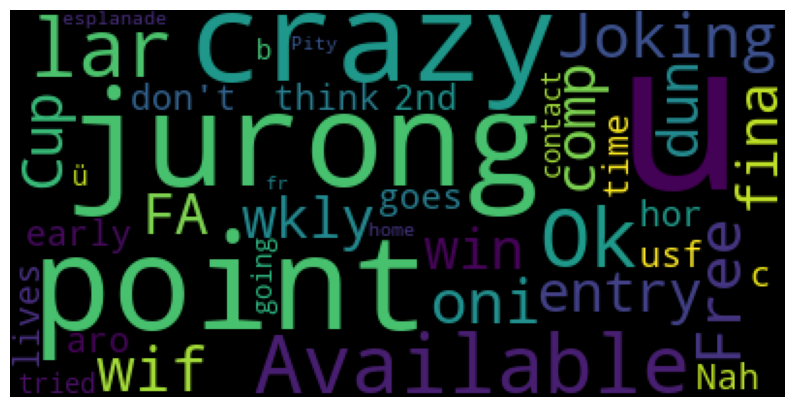

In [14]:
wordcloud = WordCloud(stopwords=stop_words, max_words=40).generate(str(spam_df['Message']))

print(wordcloud)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# Data prefactoring

### Preproces Words

In [16]:
spam_df['Message'].head(10)

0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
2    Free entry in 2 a wkly comp to win FA Cup fina...
3    U dun say so early hor... U c already then say...
4    Nah I don't think he goes to usf, he lives aro...
5    FreeMsg Hey there darling it's been 3 week's n...
6    Even my brother is not like to speak with me. ...
7    As per your request 'Melle Melle (Oru Minnamin...
8    WINNER!! As a valued network customer you have...
9    Had your mobile 11 months or more? U R entitle...
Name: Message, dtype: object

In [17]:
spam_df['Message'] = spam_df['Message'].apply(preprocess_text)

In [19]:
spam_df['Message'].head(10)

0    go until jurong point crazy available only in ...
1                              ok lar joking wif u oni
2    free entry in 2 a wkly comp to win fa cup fina...
3          u dun say so early hor u c already then say
4    nah i dont think he goes to usf he lives aroun...
5    freemsg hey there darling its been 3 weeks now...
6    even my brother is not like to speak with me t...
7    as per your request melle melle oru minnaminun...
8    winner as a valued network customer you have b...
9    had your mobile 11 months or more u r entitled...
Name: Message, dtype: object

In [20]:
most_common_result = analyze_word_frequency_in_df_column(spam_df, 'Message', 20, mode = "most_common")
least_common_result = analyze_word_frequency_in_df_column(spam_df, 'Message', 20, mode = "least_common")
print(most_common_result)
print(least_common_result)

{'i': 2250, 'to': 2248, 'you': 2129, 'a': 1442, 'the': 1330, 'u': 1131, 'and': 971, 'is': 892, 'in': 886, 'me': 802, 'my': 757, 'for': 710, 'your': 677, 'it': 625, 'of': 620, 'call': 575, 'have': 573, 'on': 536, 'that': 517, 'are': 490}
{'bitching': 1, 'suggestions': 1, 'soany': 1, 'pity': 1, 'now1': 1, '087187272008': 1, '£750': 1, 'salesman': 1, 'lowes': 1, 'heap': 1, 'dump': 1, 'nmde': 1, 'dental': 1, '4years': 1, 'accent': 1, 'units': 1, 'pshewmissing': 1, 'shud': 1, 'kane': 1, 'influx': 1}


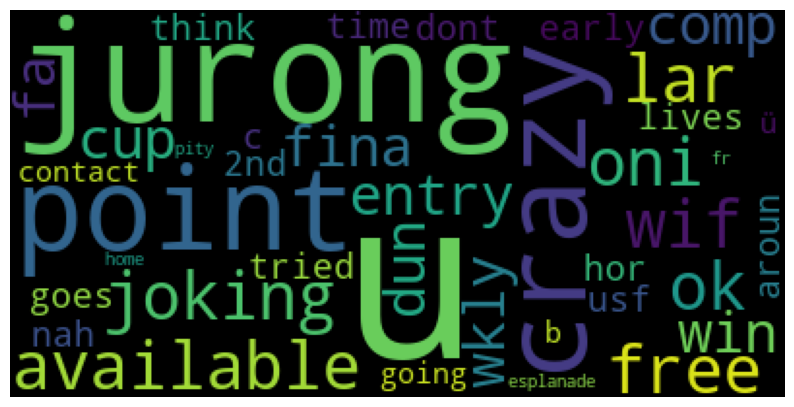

In [21]:
wordcloud = WordCloud(stopwords=stop_words, max_words=40).generate(str(spam_df['Message']))

print(wordcloud)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### Augument Data

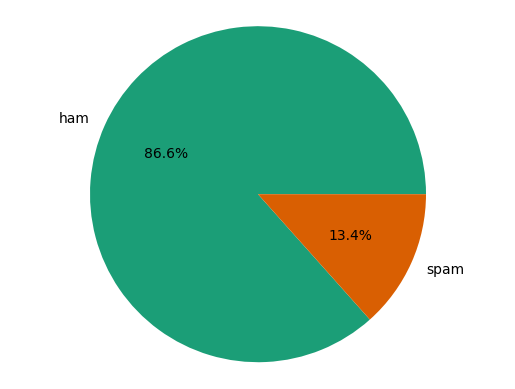

In [22]:
spam_df.groupby('Category').size().plot(kind='pie', colors=sns.color_palette('Dark2'), autopct='%1.1f%%')
plt.axis('equal')
plt.show()

In [23]:
spam_df = augment_data(spam_df, "Category" ,'Message')

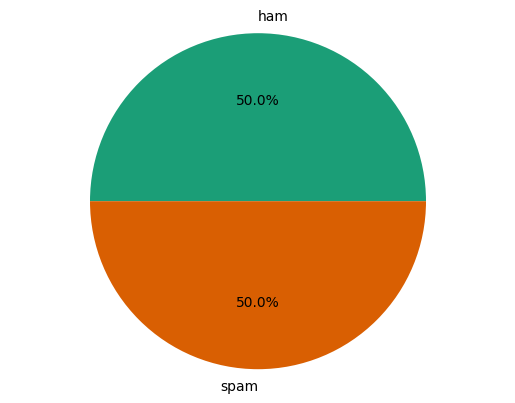

In [24]:
spam_df.groupby('Category').size().plot(kind='pie', colors=sns.color_palette('Dark2'), autopct='%1.1f%%')
plt.axis('equal')
plt.show()

# Model Training

In [25]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(spam_df.Message, spam_df.Category, test_size=0.25)

In [26]:
# Create a pipeline for the model
clf=Pipeline([
    ('vectorizer',CountVectorizer()),
    ('nb',MultinomialNB())
])

In [27]:
# Fit the model on the training data
clf.fit(X_train,y_train)

Pipeline(steps=[('vectorizer', CountVectorizer()), ('nb', MultinomialNB())])

In [28]:
# Predict the categories for the test set
y_pred = clf.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Percentage coverage: {accuracy * 100}%")

# Additional: Cross-validation to get a more robust estimate of performance
cv_accuracy = cross_val_score(clf, spam_df.Message, spam_df['Category'], cv=5, scoring='accuracy')
print(f"Cross-validated Accuracy: {np.mean(cv_accuracy) * 100}%")

Percentage coverage: 98.96394529631165%
Cross-validated Accuracy: 98.67357512953369%
